In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

### First step
Load all the train set's tables and concatenate them for a general view of the data

In [2]:
train_path = 'data/train/'

train_dfs_list = [pd.read_csv(train_path + file, sep='|') for file in os.listdir(train_path)]
train_dfs_list_lengths = [len(df) for df in train_dfs_list]
train_df = pd.concat(train_dfs_list, sort=False, ignore_index=True)
del train_dfs_list
train_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,0,NaN,NaN,-679.93,1,0
1,58.5,96.0,NaN,133.0,54.0,30.0,28.5,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,0,NaN,NaN,-679.93,2,0
2,54.0,97.0,36.4,128.0,58.0,36.0,23.0,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,0,NaN,NaN,-679.93,3,0
3,58.0,97.0,NaN,116.0,50.0,28.0,21.0,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,0,NaN,NaN,-679.93,4,0
4,58.0,98.0,NaN,128.0,65.0,49.0,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,0,NaN,NaN,-679.93,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754812,85.0,92.0,NaN,116.0,93.0,79.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,1,1.0,0.0,-54.03,33,0
754813,87.0,94.0,36.9,137.0,107.0,91.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,1,1.0,0.0,-54.03,34,0
754814,121.0,97.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,1,1.0,0.0,-54.03,35,0
754815,95.0,91.0,NaN,138.5,107.0,87.5,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,1,1.0,0.0,-54.03,36,0


### Features types
As we can see, all the features are numerical:

In [3]:
train_df.dtypes

HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 float64
PTT                 float64
WBC                 float64
Fibrinogen          float64
Platelets           float64
Age                 float64
Gender              

### Tables length distribution
The patients' tables vary in size, with average of ~38 rows and standard deviation of ~22. This detail should be taken into account when addressing the temporal aspect of the tables, as we do later.

Mean tables lengths: 37.74085
STD tables lengths: 21.754626893548416


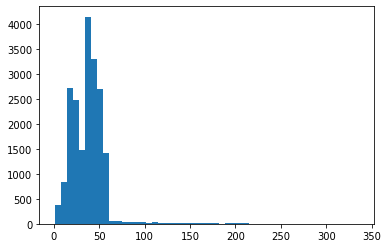

In [4]:
plt.hist(train_dfs_list_lengths, 50)
print(f'Mean tables lengths: {sum(train_dfs_list_lengths)/len(train_dfs_list_lengths)}')
print(f'STD tables lengths: {np.std(np.array(train_dfs_list_lengths))}')
plt.show()

### Missing Data and Data Distribution
As can be seen from the following summary, the vast majority of columns have most of their values missing, and in many cases, more than 90% of the data is missing. This should be addressed when preparing the data for modeling and prediction.

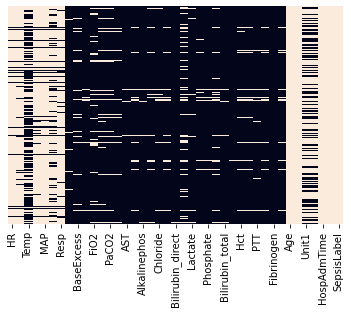

In [5]:
sns.heatmap(train_df.isnull(), cbar=False, yticklabels=False, cmap='rocket_r')
plt.show()

The following shows that only few columns distribute normaly (for example, age). Most of the distributions are very skewed, almost exponentialy. This holds in particular in columns with majority of their values missing.

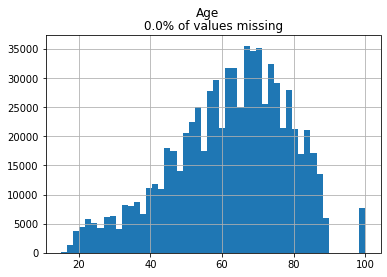

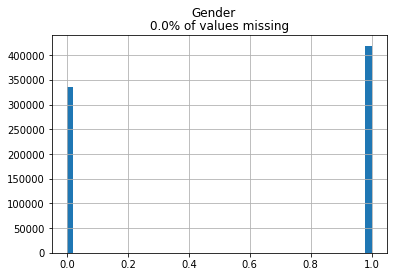

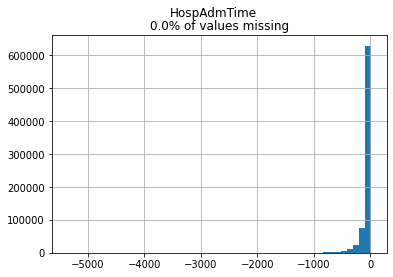

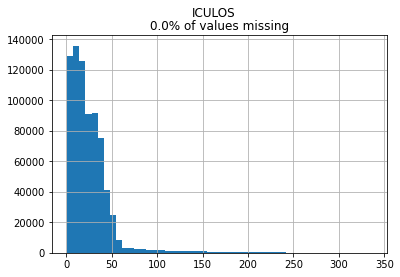

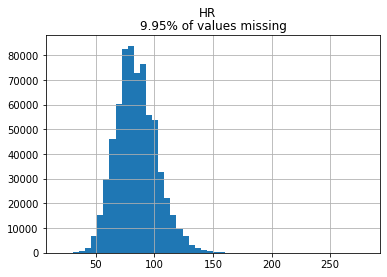

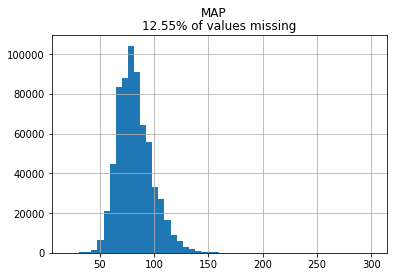

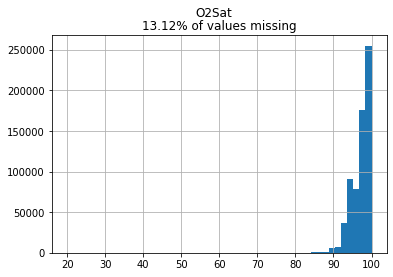

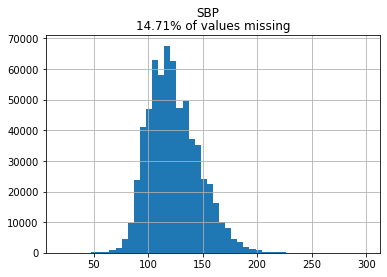

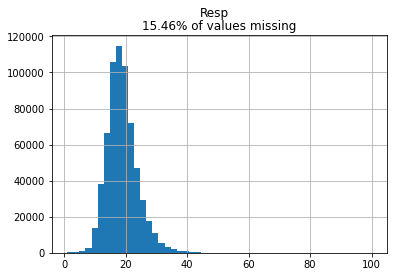

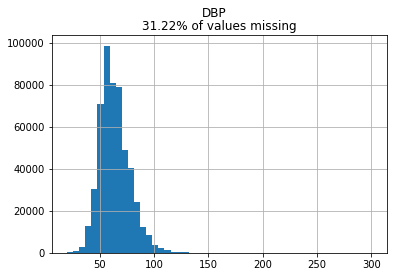

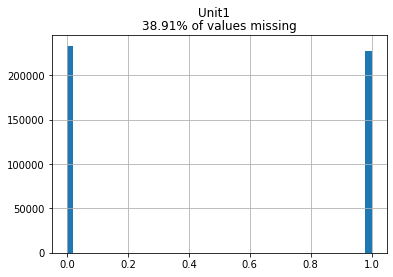

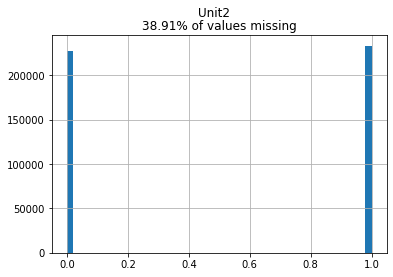

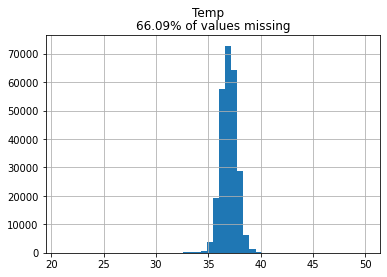

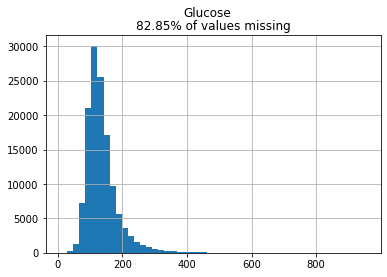

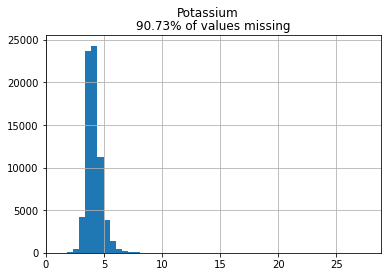

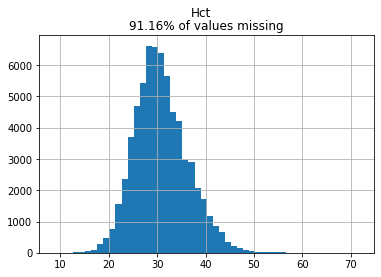

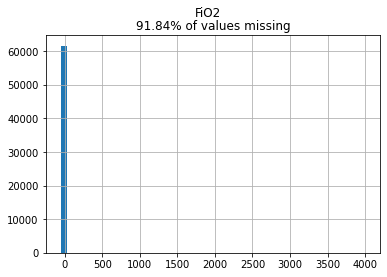

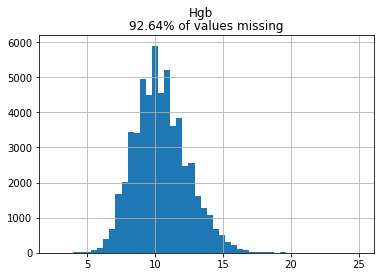

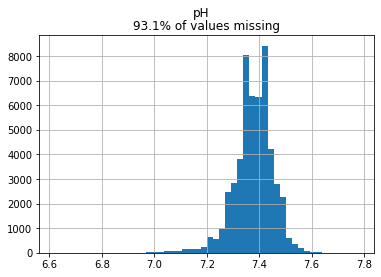

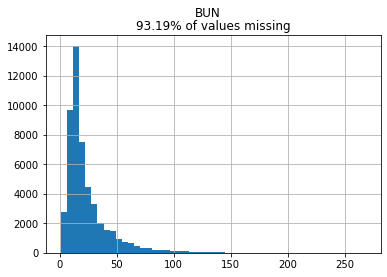

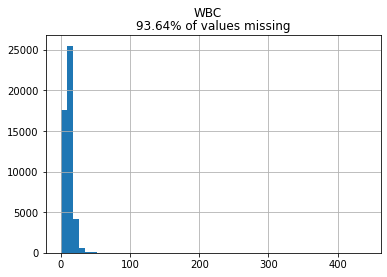

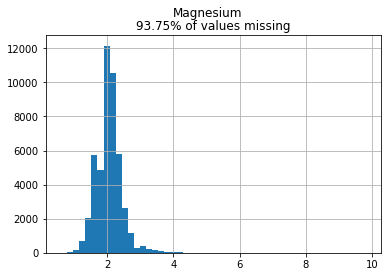

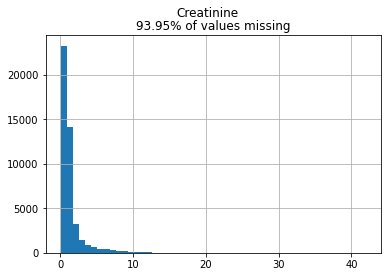

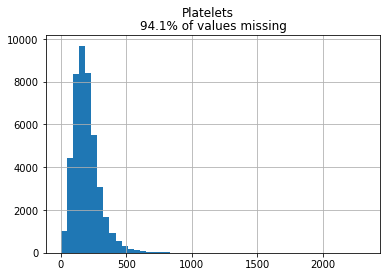

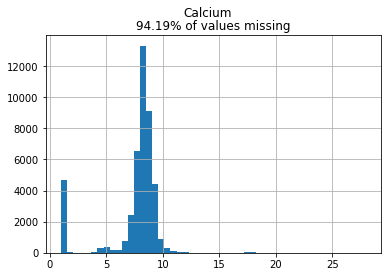

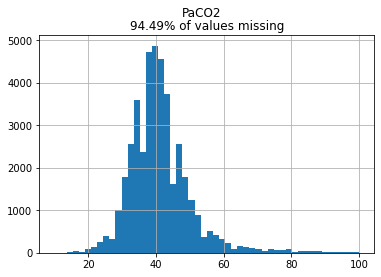

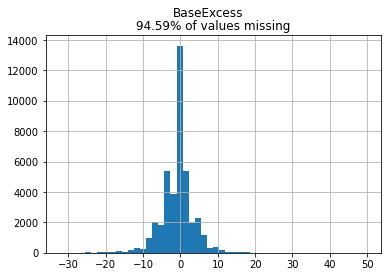

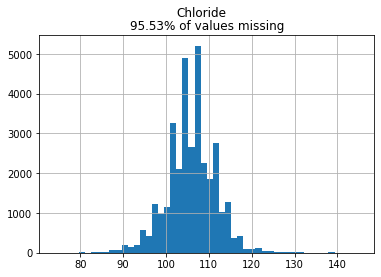

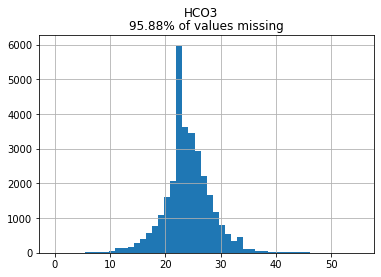

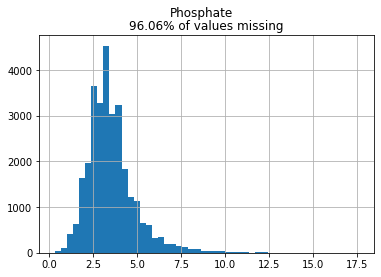

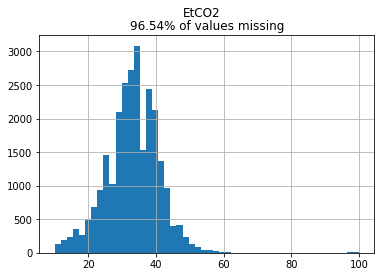

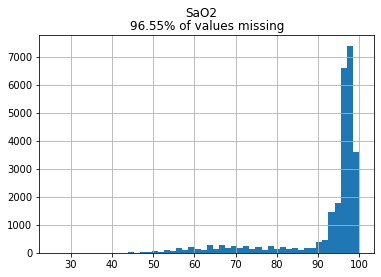

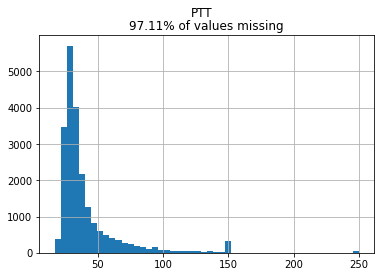

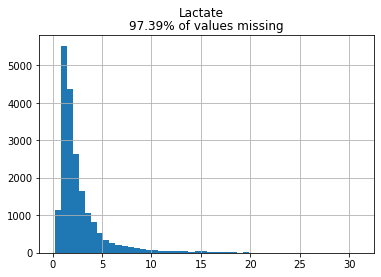

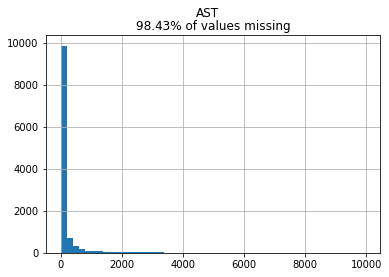

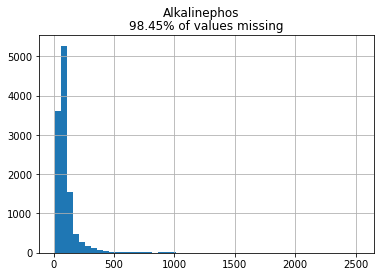

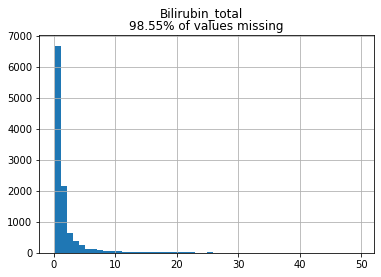

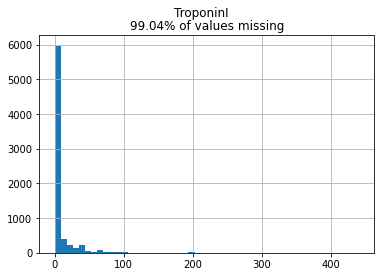

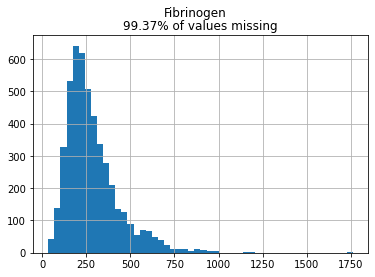

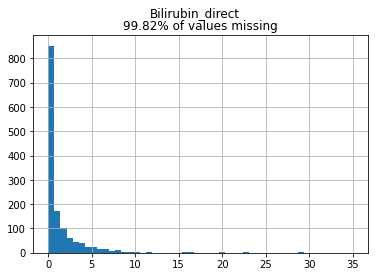

In [6]:
n_lines = len(train_df)
col_missing = sorted([(round((pd.isna(train_df[col]).sum()/n_lines)*100, 2), col) for col in list(train_df.columns)[:-1]])

for miss_rate, col in col_missing:
    train_df[col].hist(bins=50)
    plt.suptitle(col)
    plt.title(f'{miss_rate}% of values missing')
    plt.show()    

### Missing Values
In many cases, missing values can be dropped in the early stages of the EDA. In our case, the missing values rates are so high we must address them, because dropping rows with missing values will result in losing the vast majority of our data. A better practice would be to try to fill them in.

In [7]:
cols_with_missing = [col for miss_rate, col in col_missing][4:]
cols_with_missing_not_binary = [col for col in cols_with_missing if col not in ['Unit1', 'Unit2']]
cols_with_full = [col for miss_rate, col in col_missing][:4]

### Feature analysis
To start to get a sense of which features are important, we can start with a straight-forward method, using correlation:

In [8]:
# correlation of features with the SepsisLabel column
train_df.corr()['SepsisLabel'].sort_values()

Fibrinogen         -0.029998
Bilirubin_direct   -0.016535
Calcium            -0.011579
Unit2              -0.008301
AST                -0.007129
Platelets          -0.006265
HospAdmTime        -0.005137
Alkalinephos       -0.004591
O2Sat              -0.002997
DBP                -0.002701
EtCO2              -0.002275
Phosphate          -0.002156
MAP                -0.002055
SBP                -0.001199
HCO3               -0.001102
Hct                -0.000869
FiO2               -0.000133
Age                 0.000575
Hgb                 0.000960
pH                  0.001062
SaO2                0.001595
Chloride            0.001638
Gender              0.002259
Creatinine          0.002353
Magnesium           0.002569
Potassium           0.002610
Glucose             0.003093
Bilirubin_total     0.005027
BUN                 0.005390
PaCO2               0.006386
WBC                 0.007189
Unit1               0.008301
Lactate             0.008764
BaseExcess          0.009272
Temp          

As can be seen from the above cell, no feature has a strong correlation with SepsisLabel, but it doesn't rule out their importance. The data is time-based and the most of it is missing. Thus, the correlation measure may not be very informative in this case.

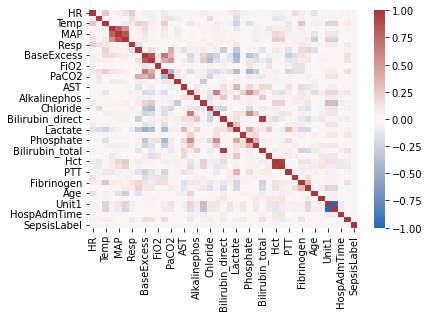

In [9]:
sns.heatmap(train_df.corr(), cmap='vlag')
plt.show()

In [10]:
corr_comb_set = set()
for i, row in train_df.corr().iterrows():
    for col in train_df.columns:
        corr = row[col]
        if 0.4 < abs(corr) < 1 or corr == -1:
            corr_comb_set.add((tuple(sorted((i, col))), corr))

for cols, corr in sorted(list(corr_comb_set), key=lambda x: x[1], reverse=True):
    print(f"Correlation between {cols[0]} and {cols[1]} is: {round(corr, 3)}")

Correlation between Bilirubin_direct and Bilirubin_total is: 0.956
Correlation between Hct and Hgb is: 0.954
Correlation between DBP and MAP is: 0.851
Correlation between BaseExcess and HCO3 is: 0.848
Correlation between MAP and SBP is: 0.782
Correlation between BaseExcess and pH is: 0.657
Correlation between BUN and Creatinine is: 0.631
Correlation between Creatinine and Phosphate is: 0.545
Correlation between DBP and SBP is: 0.542
Correlation between BUN and Phosphate is: 0.542
Correlation between HCO3 and PaCO2 is: 0.536
Correlation between EtCO2 and PaCO2 is: 0.42
Correlation between Lactate and Phosphate is: 0.402
Correlation between Lactate and pH is: -0.401
Correlation between Chloride and HCO3 is: -0.406
Correlation between Phosphate and pH is: -0.421
Correlation between PaCO2 and pH is: -0.428
Correlation between BaseExcess and Lactate is: -0.474
Correlation between Unit1 and Unit2 is: -1.0


### Global feature engineering
These values will be used later in the feature engineering process when filling missing values after linear interpolation.

In [21]:
# global_values_dict = train_df[cols_with_missing_not_binary]#.median()#.apply(lambda x: math.log(abs(x)+1)).to_dict()
global_values_dict = {}
for col in cols_with_missing_not_binary:
    global_values_dict[col] = train_df[col].dropna().apply(lambda x: math.log(abs(x)+1)).median()
global_values_dict['Unit1'] = train_df['Unit1'].mean()
global_values_dict['Unit2'] = train_df['Unit2'].mean()
global_values_dict

{'HR': 4.430816798843313,
 'MAP': 4.394449154672439,
 'O2Sat': 4.59511985013459,
 'SBP': 4.804021044733257,
 'Resp': 2.9444389791664403,
 'DBP': 4.143134726391533,
 'Temp': 3.6375861597263857,
 'Glucose': 4.852030263919617,
 'Potassium': 1.62924053973028,
 'Hct': 3.4436180975461075,
 'FiO2': 0.4054651081081644,
 'Hgb': 2.424802725718295,
 'pH': 2.1258479144939915,
 'BUN': 2.8903717578961645,
 'WBC': 2.424802725718295,
 'Magnesium': 1.0986122886681098,
 'Creatinine': 0.6471032420585385,
 'Platelets': 5.209486152841421,
 'Calcium': 2.2300144001592104,
 'PaCO2': 3.713572066704308,
 'BaseExcess': 1.0986122886681098,
 'Chloride': 4.672828834461906,
 'HCO3': 3.2188758248682006,
 'Phosphate': 1.4586150226995167,
 'EtCO2': 3.5263605246161616,
 'SaO2': 4.584967478670572,
 'PTT': 3.505557396986398,
 'Lactate': 1.0560511619596922,
 'AST': 3.713572066704308,
 'Alkalinephos': 4.30406509320417,
 'Bilirubin_total': 0.5877866649021191,
 'TroponinI': 0.26236426446749106,
 'Fibrinogen': 5.51745289646470

### Saving objects for later use

In [22]:
import pickle

col_lists_dict = {'cols_with_missing': cols_with_missing,
                  'cols_with_missing_not_binary': cols_with_missing_not_binary,
                  'cols_with_full': cols_with_full}

with open('EDA_pickles/col_lists_dict.pkl', 'wb') as file:
    pickle.dump(col_lists_dict, file)
    
with open('EDA_pickles/global_values_dict.pkl', 'wb') as file:
    pickle.dump(global_values_dict, file)